# Tf-Idf + Stratification w.r.t. keyword and target

In [1]:
import pandas as pd
from pathlib import Path
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import cross_validate, learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# BASE_DIR = Path('/home/giovenko/Projects/real_or_not')
HOME_DIR = Path.home()
BASE_DIR = Path(HOME_DIR/'Projects/real_or_not')
INPUT_DIR = BASE_DIR/'data/input'
OUTPUT_DIR = BASE_DIR/'data/output'

In [3]:
train_df = pd.read_csv(INPUT_DIR/'train.csv')
test_df = pd.read_csv(INPUT_DIR/'test.csv')

train_df['keyword'] = train_df.keyword.fillna('missing')
train_df['str_target'] = train_df.target.apply(lambda x: str(x))
train_df['keyword_target'] = train_df.keyword.str.cat(train_df.str_target)

test_df['keyword'] = test_df.keyword.fillna('missing')

In [4]:
pipe = Pipeline([
    ('cvec', TfidfVectorizer(stop_words='english')),
    ('clf', RidgeClassifier())
])

In [5]:
# Cross validation scheme stratified by keyword
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv = skf.split(train_df, train_df.target)

## `cross_validate`

In [6]:
model = clone(pipe)
scores = cross_val_score(model, train_df['text'], train_df['target'], scoring='f1', cv=cv)
print('score: {:.3f} +/- {:.3f}'.format(scores.mean(), 2*scores.std()))

score: 0.752 +/- 0.017


In [7]:
model = clone(pipe)
cv = skf.split(train_df, train_df.target)
scores = cross_validate(model, train_df['text'], train_df['target'], scoring='f1', cv=cv, return_train_score=True)
print(pd.DataFrame(scores))

   fit_time  score_time  test_score  train_score
0  0.102859    0.036826    0.761600     0.967465
1  0.081157    0.035374    0.757895     0.965114
2  0.086012    0.037368    0.740331     0.966148
3  0.087776    0.036981    0.743134     0.967567
4  0.088459    0.036885    0.757017     0.967302


## `learning_curves`

In [8]:
model = clone(pipe)
cv = skf.split(train_df, train_df.target)
lc = learning_curve(model, train_df.text, train_df.target, cv=cv, scoring='f1', random_state=42)

In [9]:
lc

(array([ 609, 1979, 3349, 4719, 6090]),
 array([[0.97014925, 0.97757848, 0.96412556, 0.97654584, 0.98297872],
        [0.97920858, 0.97924773, 0.97392438, 0.97459893, 0.98023715],
        [0.97844355, 0.97736256, 0.97002924, 0.9722122 , 0.9756275 ],
        [0.96710023, 0.96682704, 0.96493902, 0.96675192, 0.96867838],
        [0.96746542, 0.96511401, 0.96614786, 0.96755391, 0.96728972]]),
 array([[0.42994652, 0.47204969, 0.50455927, 0.50398406, 0.5155642 ],
        [0.6238698 , 0.66958808, 0.64995678, 0.64111498, 0.65164645],
        [0.71262458, 0.73344103, 0.70483871, 0.69424169, 0.70703764],
        [0.74939173, 0.7568438 , 0.72230889, 0.72944932, 0.74641148],
        [0.7616    , 0.75789474, 0.74033149, 0.74313409, 0.75801282]]))

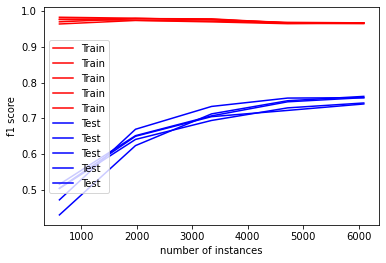

In [10]:
import matplotlib.pyplot as plt
plt.plot(lc[0], lc[1], '-r', label='Train')
plt.plot(lc[0], lc[2], '-b', label='Test')
plt.xlabel('number of instances')
plt.ylabel('f1 score')
plt.legend()

## Inspecting overfitting

We have many more features than we have observations.

In [11]:
model.fit(train_df['text'], train_df['target'])
print('N. features: {}\nN. instances: {}'.format(len(model['cvec'].vocabulary_),
                                                  train_df.shape[0]))

N. features: 21363
N. instances: 7613


However, neither selecting the top 1000, 5000, 10000 Tf-Idf features, nor increasing the value of `alpha` has a beneficial effect, in the sense that both the training and the validation performances degrade.

One surprising thing is that the optimal `alpha` value is 1, i.e. the default value. This is a strange coincidence.

In [12]:
param_grid = {
    'cvec__max_df': [0.5, 0.7, 0.9]
}

model = clone(pipe)
cv = skf.split(train_df, train_df.target)

gscv = GridSearchCV(model, param_grid, scoring='f1', cv=cv)
gscv.fit(train_df.text, train_df.target)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f1a59b056d0>,
             estimator=Pipeline(steps=[('cvec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf', RidgeClassifier())]),
             param_grid={'cvec__max_df': [0.5, 0.7, 0.9]}, scoring='f1')

In [13]:
gscv.best_params_

{'cvec__max_df': 0.5}

In [14]:
gscv.best_score_

0.7519954312418587

In [15]:
from sklearn.naive_bayes import MultinomialNB

pipe = Pipeline([
    ('vec', CountVectorizer()),
    ('clf', MultinomialNB())
])

In [16]:
model = clone(pipe)
cv = skf.split(train_df, train_df.target)
param_grid = {
    'vec__max_df': [0.5, 0.7, 0.9],
    'vec__strip_accents': (None, 'ascii', 'unicode'),
    'vec__stop_words': (None, 'english')
}

gscv = GridSearchCV(model, param_grid = param_grid, scoring='f1', cv=cv)
gscv.fit(train_df.text, train_df.target)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f1a59948900>,
             estimator=Pipeline(steps=[('vec', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             param_grid={'vec__max_df': [0.5, 0.7, 0.9],
                         'vec__stop_words': (None, 'english'),
                         'vec__strip_accents': (None, 'ascii', 'unicode')},
             scoring='f1')

In [17]:
gscv.cv_results_['mean_test_score'].max(), gscv.cv_results_['mean_test_score'].std()

(0.7579921200164805, 0.0021125134337367252)

In [18]:
cv = skf.split(train_df, train_df.target)
scores = cross_val_score(gscv.best_estimator_, train_df['text'], train_df['target'], scoring='f1', cv=cv)
print('score: {:.3f} +/- {:.3f}'.format(scores.mean(), 2*scores.std()))

score: 0.758 +/- 0.029


In [19]:
sample_submission = pd.read_csv(INPUT_DIR/'sample_submission.csv')
sample_submission['target'] = gscv.predict(test_df.text)
sample_submission.to_csv(OUTPUT_DIR/'submission_cvec_target_multinomNB.csv', index=False)